<a href="https://colab.research.google.com/github/AlexandreLarget/indus_defect_detection/blob/main/Pump_impeller_defect_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context

The dataset comes from casting manufacturing company that casts submersible pump impellers.

It is originally composed of 1300 images of size 512x512 px. 519 are images of pieces without defect, 719 are pieces with defects.

We will build a classifier for the quality inspection department in order to improve the quality of the inspection process.

In [1]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-92160bcc-ebd8-f096-6705-19feda6d6c9e)


## Get the data

The data are available on Kaggle, at the following link : 

https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product

In [2]:
!pip install -q kaggle

In [3]:
 from google.colab import files 
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexandrelarget","key":"aa9f8e3ee2ac85913cec1ab4c0fba1e5"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

 82% 82.0M/100M [00:00<00:00, 84.6MB/s]
100% 100M/100M [00:01<00:00, 101MB/s]  


In [ ]:
!unzip "/content/real-life-industrial-dataset-of-casting-product.zip" -d "/content/data/"

## Import librairies

In [7]:
import os
import shutil
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import pandas as pd
import time

## Discover the data

In this step, we will get familiar with the data, find the number of images available, visualize some data.

In [8]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

In [9]:
walk_through_dir("/content/data")

There are 2 directories and 0 files in '/content/data'.
There are 1 directories and 0 files in '/content/data/casting_512x512'.
There are 2 directories and 0 files in '/content/data/casting_512x512/casting_512x512'.
There are 0 directories and 519 files in '/content/data/casting_512x512/casting_512x512/ok_front'.
There are 0 directories and 781 files in '/content/data/casting_512x512/casting_512x512/def_front'.
There are 1 directories and 0 files in '/content/data/casting_data'.
There are 2 directories and 0 files in '/content/data/casting_data/casting_data'.
There are 2 directories and 0 files in '/content/data/casting_data/casting_data/test'.
There are 0 directories and 262 files in '/content/data/casting_data/casting_data/test/ok_front'.
There are 0 directories and 453 files in '/content/data/casting_data/casting_data/test/def_front'.
There are 2 directories and 0 files in '/content/data/casting_data/casting_data/train'.
There are 0 directories and 2875 files in '/content/data/casti

The dataset is divided in two files:
- one with the raw data
- one where data have been preprocessed and augmented

For the completion of our case, we will use the original data and preprocess and augment it ourself.



In [10]:
shutil.rmtree("/content/data/casting_data")

In [11]:
data_dir = "/content/data/casting_512x512/casting_512x512"

In [12]:
def visualize_random_data(dir, num_of_plot_per_classe=3):

  dir_def = dir + "/def_front"
  dir_ok = dir + "/ok_front"
  files_def = [os.path.join(path, filename) for path, dirs, files in os.walk(dir_def) for filename in files]
  files_ok = [os.path.join(path, filename) for path, dirs, files in os.walk(dir_ok) for filename in files]

  short_list_def = np.random.choice(files_def, num_of_plot_per_classe)
  short_list_ok = np.random.choice(files_ok, num_of_plot_per_classe)

  for i in range(num_of_plot_per_classe):
    img_def = Image.open(short_list_def[i])
    img_ok = Image.open(short_list_ok[i])
    plt.figure(figsize=(8,4))
    plt.suptitle("Left: with defect | Right: no defect")
    plt.subplot(1,2,1)
    plt.imshow(img_def)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(img_ok)
    plt.axis("off")

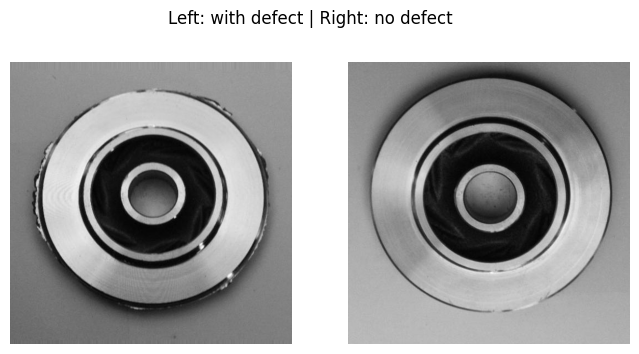

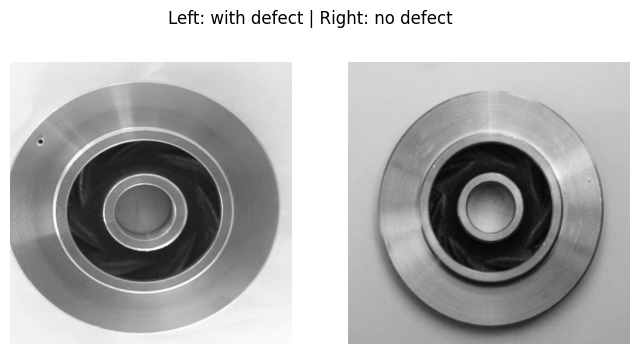

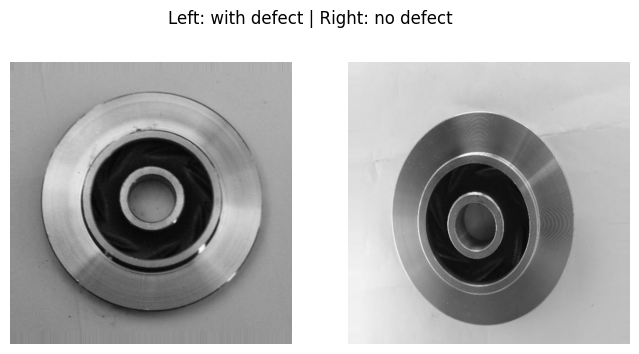

In [13]:
visualize_random_data(data_dir)

## Data preprocessing

In this step, we will prepare the data for our models.
Visualizing the data, we saw that they are quite clean. 

However, we will need to increase the number of image available (1300 is a small amount for deep learning), plus the pieces aren't center each time (they are even some photo were the pieces are cropped).
For these two reasons, we will augment the data (particularly zoom in and out).

#### Preprocessing

In [14]:
batch_size = 32
img_size = 224
input_shape=(img_size, img_size, 3)

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.3,
                                                       subset="training",
                                                       image_size=(img_size, img_size),
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=123)

Found 1300 files belonging to 2 classes.
Using 910 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.3,
                                                     subset="validation",
                                                     image_size=(img_size, img_size),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     seed=123)

Found 1300 files belonging to 2 classes.
Using 390 files for validation.


In [17]:
test_ds = val_ds.take(int(len(val_ds)*0.5))
val_ds = val_ds.skip(int(len(val_ds)*0.5))

In [18]:
class_names = train_ds.class_names
print(class_names)

['def_front', 'ok_front']


In [19]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

#### Data augmentation

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomZoom(height_factor=0.3, width_factor=0.3),
    layers.RandomBrightness(0.3, value_range=(0.0, 1.0)),
    layers.RandomContrast(0.3),
    layers.RandomFlip(mode="horizontal_and_vertical")
    ])

## Model 0: VGG16

#### Build the model

In [21]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(img_size, img_size, 3))

In [22]:
vgg.trainable = True

In [23]:
def vgg_model():
  input = layers.Input(shape=input_shape)
  augmentation = data_augmentation(input)
  x = vgg(augmentation)
  x = layers.GlobalMaxPooling2D()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(512, activation="relu")(x)
  x = layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(inputs=input, outputs=x)
  return model

In [24]:
vgg_model = vgg_model()

In [25]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                             

In [26]:
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])

#### Train the model

In [27]:
filepath = "/content/saved_model/vgg/"
best_model = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, save_weights_only=True, monitor="val_loss")
modif_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

In [28]:
start_time = time.time()
history = vgg_model.fit(train_ds, batch_size=batch_size, epochs=100, validation_data=val_ds, callbacks=[best_model, modif_lr, early_stop])
total_time_vgg = time.time() - start_time
print(f"Training realize in {total_time_vgg:.2} secondes")

Epoch 1/100
29/29 [==============================] - 26s 247ms/step - loss: 0.6798 - accuracy: 0.5945 - val_loss: 0.6714 - val_accuracy: 0.5808 - lr: 1.0000e-04
Epoch 2/100
29/29 [==============================] - 4s 149ms/step - loss: 0.6638 - accuracy: 0.6055 - val_loss: 0.6604 - val_accuracy: 0.5808 - lr: 1.0000e-04
Epoch 3/100
29/29 [==============================] - 5s 161ms/step - loss: 0.6396 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6566 - lr: 1.0000e-04
Epoch 4/100
29/29 [==============================] - 4s 150ms/step - loss: 0.6140 - accuracy: 0.6352 - val_loss: 0.5908 - val_accuracy: 0.7525 - lr: 1.0000e-04
Epoch 5/100
29/29 [==============================] - 4s 136ms/step - loss: 0.6054 - accuracy: 0.6945 - val_loss: 0.6281 - val_accuracy: 0.7071 - lr: 1.0000e-04
Epoch 6/100
29/29 [==============================] - 4s 153ms/step - loss: 0.5654 - accuracy: 0.7176 - val_loss: 0.5375 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 7/100
29/29 [====================

In [97]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(16,4))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylim(top=1.2, bottom=0.0)
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

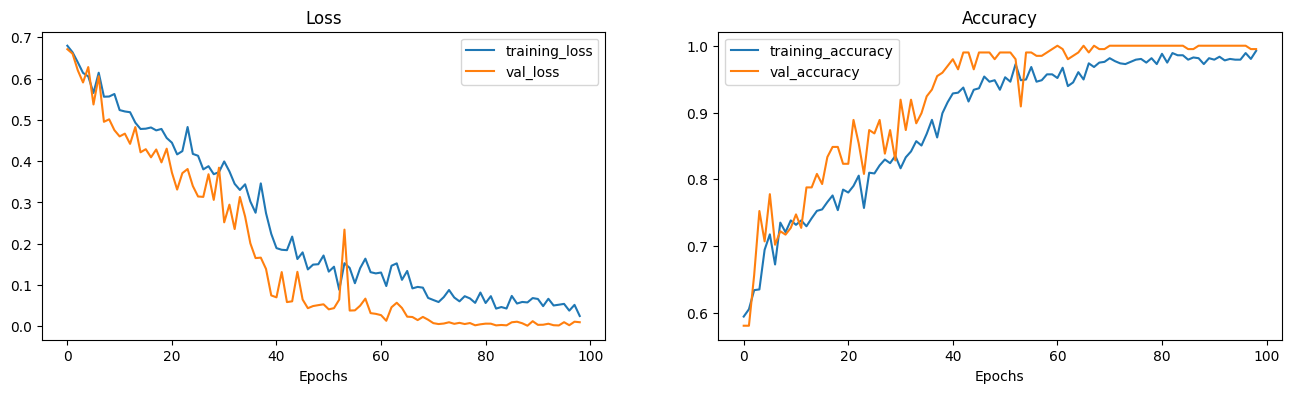

In [30]:
plot_loss_curves(history)

#### Results

In [31]:
def calculate_results(y_true, y_pred_prob):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted probabilities in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  y_pred = y_pred_prob.argmax(axis=1)
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [32]:
def display_confusion_matrix(y_true, y_pred_prob):
  """
  Display a confusion matrix.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred_prob: predicted probabilities in the form of a 1D array

  Return a seaborn plot with the confusion matrix. 
  """
  
  y_pred = y_pred_prob.argmax(axis=1)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap="viridis", fmt="d")
  plt.ylabel("real values")
  plt.xlabel("predicted values")
  plt.yticks(np.arange(2)+0.5,["negative", "positive"], rotation=0, va="center")
  plt.xticks(np.arange(2)+0.5,["negative", "positive"], rotation=0, ha="center");

In [33]:
vgg_model.load_weights(filepath)

In [34]:
_, accuracy = vgg_model.evaluate(test_ds)
print(f"On the test dataset, the model prediction are {accuracy*100:.2f}% correct.")

6/6 [==============================] - 1s 42ms/step - loss: 0.0086 - accuracy: 0.9948
On the test dataset, the model prediction are 99.48% correct.


In [35]:
vgg_pred_prob = vgg_model.predict(test_ds)

6/6 [==============================] - 0s 38ms/step


In [36]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [37]:
vgg_results = calculate_results(y_test, vgg_pred_prob)

In [38]:
vgg_results

{'accuracy': 99.47916666666666,
 'precision': 0.9948611111111111,
 'recall': 0.9947916666666666,
 'f1': 0.9947980627350184}

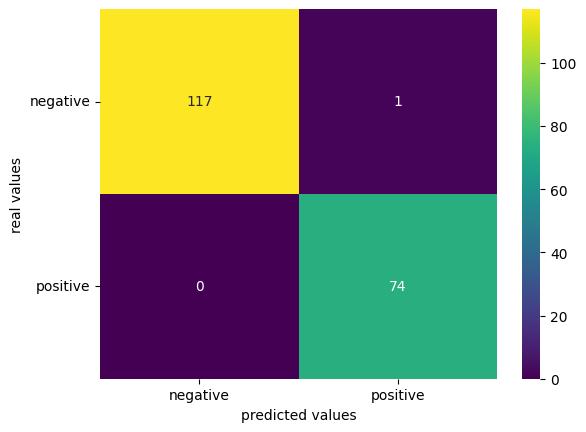

In [39]:
display_confusion_matrix(y_true=y_test, y_pred_prob=vgg_pred_prob)

In [40]:
def display_wrong_predictions(y_true, y_pred_prob):
  y_pred = y_pred_prob.argmax(axis=1)
  idx_dict = {}
  for index, (first, second) in enumerate(zip(y_test, y_pred)):
    if first != second:
      idx_dict[index] = [first, second]

  random_idx = np.random.choice(list(idx_dict.keys()), 4)
  x_test = np.concatenate([x for x, y in test_ds], axis=0).astype("int")

  plt.figure(figsize=(16,4))
  for i, j in enumerate(random_idx):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_test[j])
    plt.title(f"Real: {class_names[idx_dict[j][0]]} | Predicted: {class_names[idx_dict[j][1]]}")
    plt.axis("off");

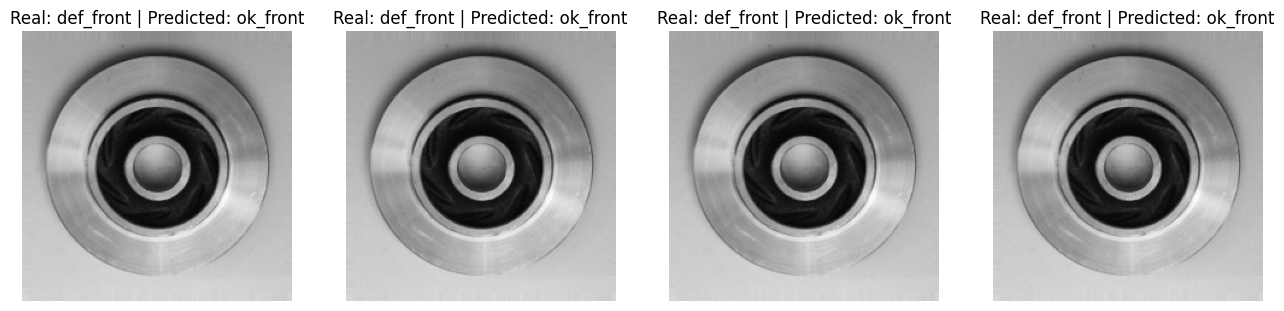

In [41]:
display_wrong_predictions(y_test, vgg_pred_prob)

In [42]:
vgg_model.save("/content/final_model/vgg.h5")

## Model 1: ResNet50

##### Build the model

In [84]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights=None, input_shape=input_shape)

In [85]:
resnet.trainable = True

In [86]:
def resnet_model():
  input = layers.Input(shape=input_shape)
  augmentation = data_augmentation(input)
  x = resnet(augmentation)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(512, activation="relu")(x)
  x = layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(inputs=input, outputs=x)
  return model

In [87]:
resnet_model = resnet_model()

In [88]:
resnet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0   

In [89]:
resnet_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])

#### Train the model

In [90]:
filepath = "/content/saved_model/resnet/"
best_model = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, save_weights_only=True, monitor="val_loss")
modif_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

In [91]:
start_time = time.time()
history = resnet_model.fit(train_ds, batch_size=batch_size, epochs=100, validation_data=val_ds, callbacks=[best_model, modif_lr, early_stop])
total_time_resnet = time.time() - start_time
print(f"Training realize in {total_time_resnet:.2} secondes")

Epoch 1/100
29/29 [==============================] - 23s 216ms/step - loss: 1.0195 - accuracy: 0.5484 - val_loss: 551856.7500 - val_accuracy: 0.5808 - lr: 0.0100
Epoch 2/100
29/29 [==============================] - 5s 172ms/step - loss: 0.7986 - accuracy: 0.5440 - val_loss: 6370.9888 - val_accuracy: 0.5808 - lr: 0.0100
Epoch 3/100
29/29 [==============================] - 4s 153ms/step - loss: 0.6844 - accuracy: 0.6077 - val_loss: 148.6092 - val_accuracy: 0.5808 - lr: 0.0100
Epoch 4/100
29/29 [==============================] - 4s 153ms/step - loss: 0.6442 - accuracy: 0.6648 - val_loss: 11.8500 - val_accuracy: 0.4192 - lr: 0.0100
Epoch 5/100
29/29 [==============================] - 3s 118ms/step - loss: 0.6438 - accuracy: 0.6440 - val_loss: 30.5762 - val_accuracy: 0.5808 - lr: 0.0100
Epoch 6/100
29/29 [==============================] - 4s 157ms/step - loss: 0.6572 - accuracy: 0.6560 - val_loss: 2.6258 - val_accuracy: 0.5808 - lr: 0.0100
Epoch 7/100
29/29 [==============================] 

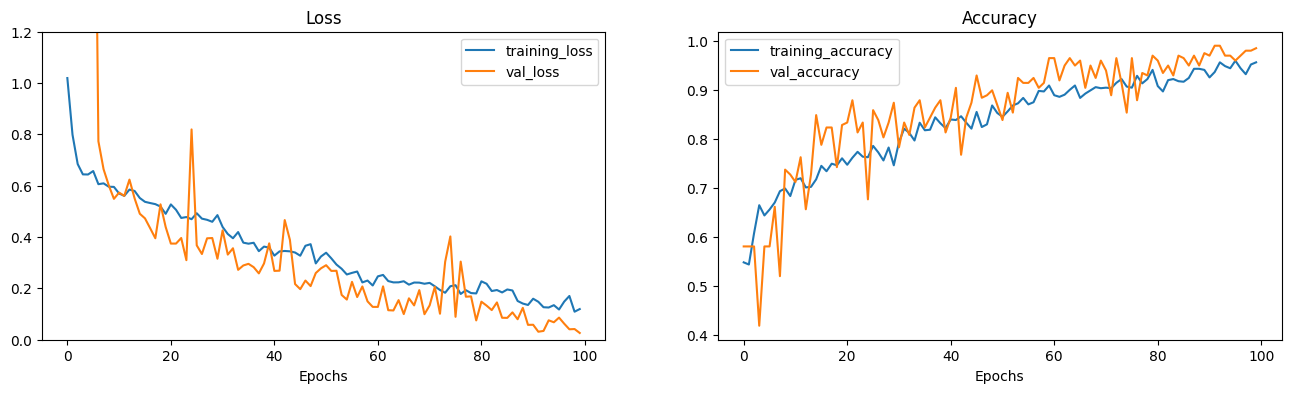

In [98]:
plot_loss_curves(history)

#### Results

In [99]:
resnet_model.load_weights(filepath)

In [100]:
_, accuracy = resnet_model.evaluate(test_ds)
print(f"On the test dataset, the model prediction are {accuracy*100:.2f}% correct.")

6/6 [==============================] - 0s 38ms/step - loss: 0.0417 - accuracy: 0.9792
On the test dataset, the model prediction are 97.92% correct.


In [101]:
resnet_pred_prob = resnet_model.predict(test_ds)

6/6 [==============================] - 1s 35ms/step


In [102]:
resnet_results = calculate_results(y_test, resnet_pred_prob)

In [103]:
resnet_results

{'accuracy': 97.91666666666666,
 'precision': 0.9791666666666666,
 'recall': 0.9791666666666666,
 'f1': 0.9791666666666666}

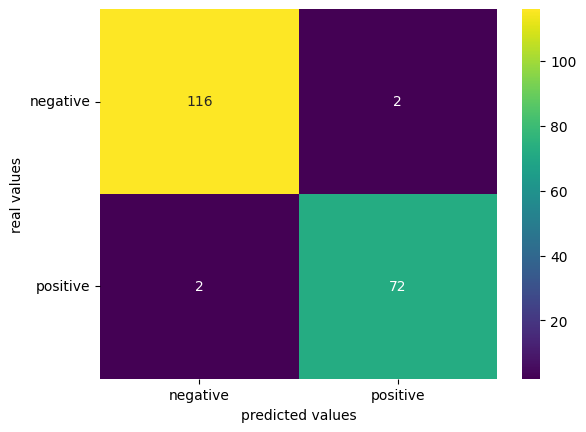

In [104]:
display_confusion_matrix(y_true=y_test, y_pred_prob=resnet_pred_prob)

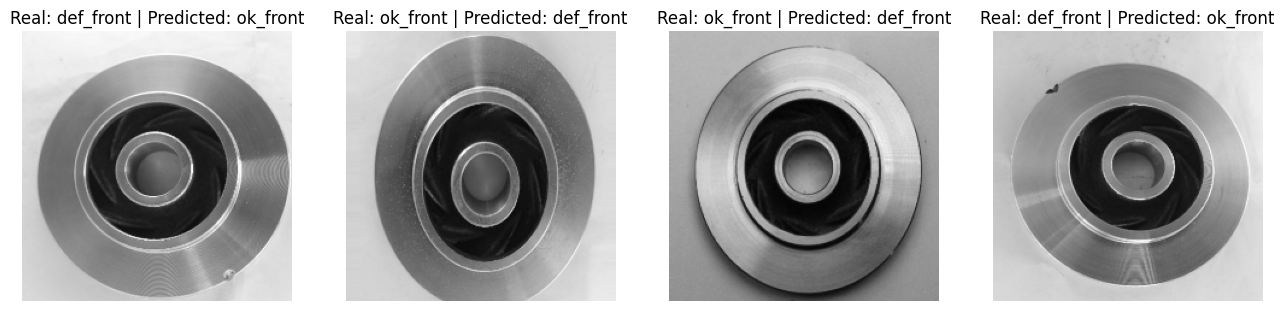

In [58]:
display_wrong_predictions(y_test, resnet_pred_prob)

In [59]:
resnet_model.save("/content/final_model/resnet.h5")

## Model 2: ViT transformer

#### Build the model

In [105]:
patch_size = 14 # patches will be (14, 14)
num_patches = (img_size // patch_size) **2 # (224 // 14)**2 = 16**2 = 256
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim,
    projection_dim *2
] # size of the transformer layer
transformer_layers = 8
mlp_head_units = [1024, 2048] # Dense layer at the end of the classifier

In [106]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation="gelu")(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

In [107]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1,1,1,1],
        padding="VALID"
    )
    patch_dims = patches.shape[-1] # patches.shape => ([1, 16, 16, 588])
    patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # patches.shape => ([1, 256, 588])
    # 256 flatten images of 588 px (14, 14, 3)
    return patches

In [108]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dims):
    super().__init__()
    self.num_patches = num_patches # 256
    self.projection = layers.Dense(units=projection_dim) # 64
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
        ) # input=256, output=64

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [109]:
def vit_model():
  inputs = layers.Input(shape=input_shape)
  augmentation = data_augmentation(inputs)
  # Create patches
  patches = Patches(patch_size)(augmentation)
  # Encode patches
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # Create multiple layers of the transformer block
  for _ in range(transformer_layers):
    # Layer normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Create a multi-head attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    # Skip connection 1
    x2 = layers.Add()([attention_output, encoded_patches])
    # Layer normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    # skip connection 2
    encoded_patches = layers.Add()([x3, x2])

  # Create a [batch_size, projection_dim] tensor
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.4)(representation)
  # Add MLP
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
  output = layers.Dense(2, activation="softmax")(features)
  model = tf.keras.Model(inputs=inputs, outputs=output)
  return model

In [110]:
vit_model = vit_model()

In [111]:
vit_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 588)    0           ['sequential[4][0]']             
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 256, 64)     54080       ['patches_1[0][0]']        

In [112]:
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])

#### Train the model

In [113]:
filepath = "/content/saved_model/vit/"
best_model = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, save_weights_only=True, monitor="val_loss")
modif_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=13)

In [114]:
start_time = time.time()
history = vit_model.fit(train_ds, batch_size=batch_size, epochs=130, validation_data=val_ds, callbacks=[best_model, modif_lr, early_stop])
total_time_vit = time.time() - start_time
print(f"Training realize in {total_time_vit:.2} secondes")

Epoch 1/130
29/29 [==============================] - 30s 125ms/step - loss: 1.9538 - accuracy: 0.5451 - val_loss: 0.9660 - val_accuracy: 0.5859 - lr: 1.0000e-04
Epoch 2/130
29/29 [==============================] - 2s 85ms/step - loss: 0.7982 - accuracy: 0.6088 - val_loss: 0.6229 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 3/130
29/29 [==============================] - 2s 85ms/step - loss: 0.7301 - accuracy: 0.6066 - val_loss: 0.5401 - val_accuracy: 0.7424 - lr: 1.0000e-04
Epoch 4/130
29/29 [==============================] - 1s 51ms/step - loss: 0.6723 - accuracy: 0.6462 - val_loss: 0.6166 - val_accuracy: 0.7323 - lr: 1.0000e-04
Epoch 5/130
29/29 [==============================] - 1s 51ms/step - loss: 0.6435 - accuracy: 0.6462 - val_loss: 0.5875 - val_accuracy: 0.6616 - lr: 1.0000e-04
Epoch 6/130
29/29 [==============================] - 1s 51ms/step - loss: 0.6600 - accuracy: 0.6198 - val_loss: 0.5763 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 7/130
29/29 [=========================

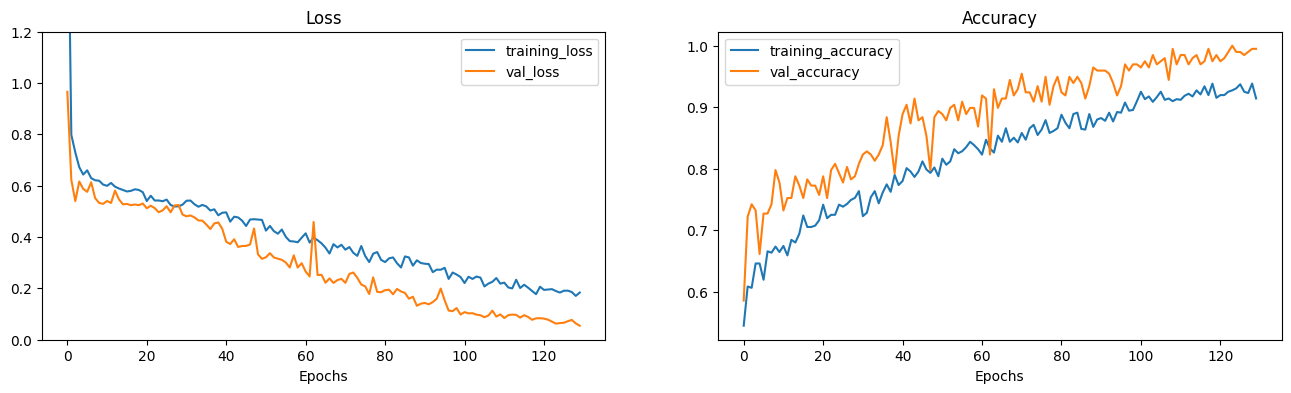

In [115]:
plot_loss_curves(history)

#### Results

In [116]:
vit_model.load_weights(filepath)

In [117]:
_, accuracy = vit_model.evaluate(test_ds)
print(f"On the test dataset, the model prediction are {accuracy*100:.2f}% correct.")

6/6 [==============================] - 0s 22ms/step - loss: 0.0910 - accuracy: 0.9792
On the test dataset, the model prediction are 97.92% correct.


In [118]:
vit_pred_prob = vit_model.predict(test_ds)

6/6 [==============================] - 1s 21ms/step


In [119]:
vit_results = calculate_results(y_test, vit_pred_prob)

In [120]:
vit_results

{'accuracy': 97.91666666666666,
 'precision': 0.9791666666666666,
 'recall': 0.9791666666666666,
 'f1': 0.9791666666666666}

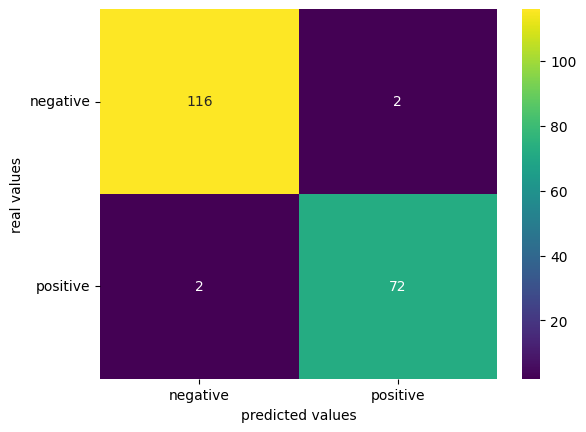

In [121]:
display_confusion_matrix(y_test, vit_pred_prob)

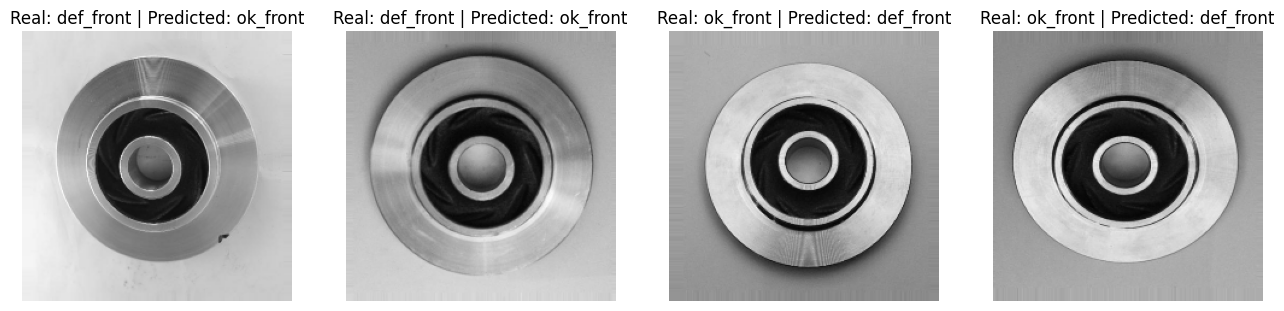

In [124]:
display_wrong_predictions(y_test, vit_pred_prob)

In [78]:
vit_model.save("/content/final_model/vit.h5")

In [125]:
!zip -r /content/saved_weights.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/vit/ (stored 0%)
  adding: content/saved_model/vit/.data-00000-of-00001 (deflated 6%)
  adding: content/saved_model/vit/checkpoint (deflated 34%)
  adding: content/saved_model/vit/.index (deflated 78%)
  adding: content/saved_model/resnet/ (stored 0%)
  adding: content/saved_model/resnet/.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/resnet/checkpoint (deflated 34%)
  adding: content/saved_model/resnet/.index (deflated 79%)
  adding: content/saved_model/vgg/ (stored 0%)
  adding: content/saved_model/vgg/.data-00000-of-00001 (deflated 10%)
  adding: content/saved_model/vgg/checkpoint (deflated 34%)
  adding: content/saved_model/vgg/.index (deflated 72%)


## Conclusion

In [126]:
results = pd.DataFrame([vgg_results, resnet_results, vit_results], index=["VGG", "ResNet", "ViT"])

In [127]:
results

,accuracy,precision,recall,f1
VGG,99.479167,0.994861,0.994792,0.994798
ResNet,97.916667,0.979167,0.979167,0.979167
ViT,97.916667,0.979167,0.979167,0.979167


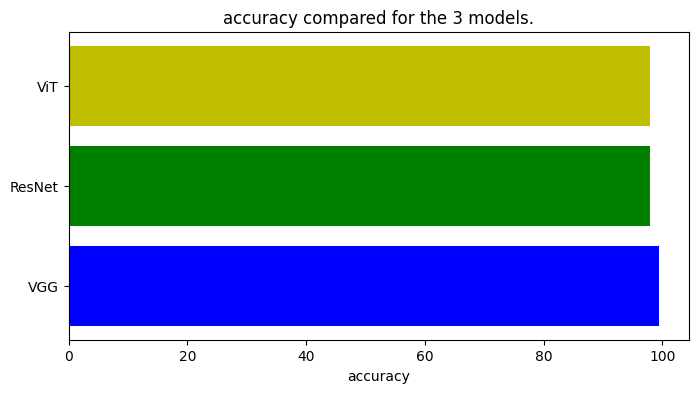

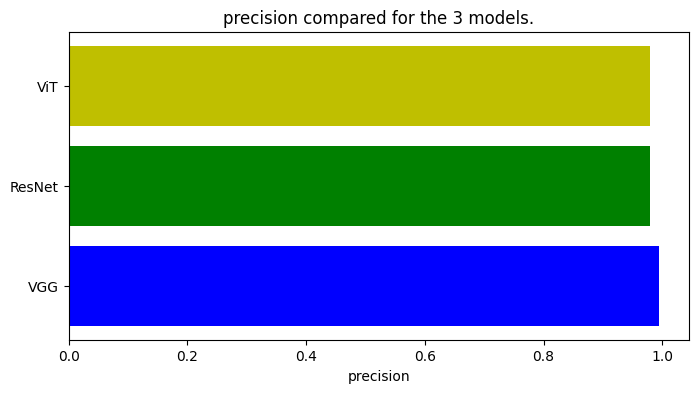

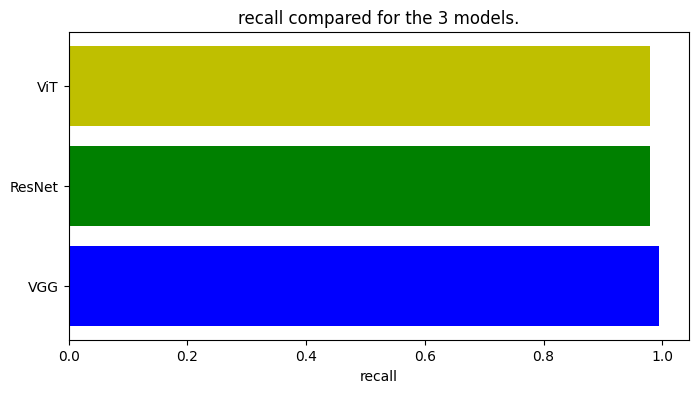

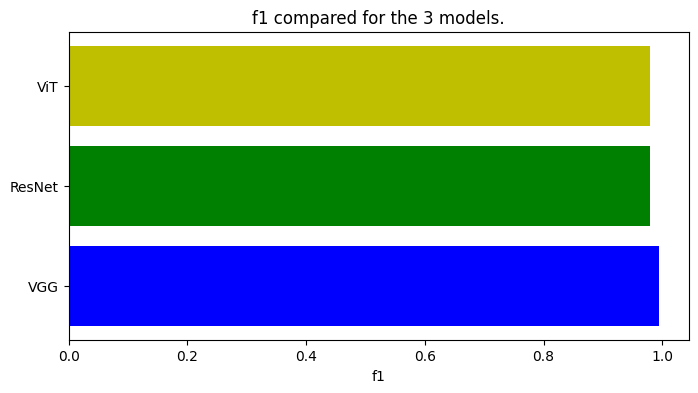

In [128]:
for i in list(results.columns):
  plt.figure(figsize=(8,4))
  plt.barh(results.index, results[i], color=["b", "g", "y"])
  plt.title(f"{i} compared for the 3 models.")
  plt.xlabel(i)

In [83]:
#import shutil
#shutil.rmtree("/content/final_model")
#shutil.rmtree("/content/saved_model")